# General 

TODO: 
Exploration of data, models and methods

In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [71]:
import cv2    
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [72]:
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [73]:
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

In [74]:
DIR = 'img/'
df = pd.read_csv('labels.csv', sep = '\s+')
#df.head()

# Cropping faces / need to train my own haar cascade

In [5]:
face_cascade = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../haarcascades/haarcascade_eye.xml')

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        #roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        #eyes = eye_cascade.detectMultiScale(roi_gray)
        #if len(eyes) >= 2:
        return roi_color

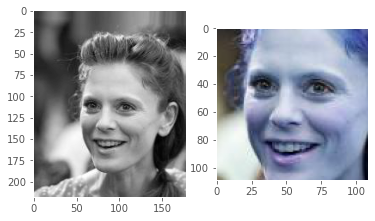

In [6]:
#Crop a test image

plt.figure(1)
plt.subplot(121)
img = cv2.imread(DIR + '1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.grid(False)

plt.subplot(122)
roi_color = get_cropped_image_if_2_eyes(DIR + '1.jpg')
plt.imshow(roi_color, cmap='gray')
plt.grid(False)
plt.show()

In [7]:
#Cropping all images
cropped_path = 'cropped'
crop_img = []
for name in df.img_name:
    path = DIR+name
    im = get_cropped_image_if_2_eyes(path)
    crop_img.append(im)

In [8]:
#Make copy of all data
gen = df.gender.copy()
smile = df.smiling.copy()
test = crop_img.copy()
print(len(test),len(gen),len(smile))

5000 5000 5000


In [9]:
#Make new list of data != None
sm = []
gn = []
te = []
for x in range(len(test)):
    if test[x] is not None:
        te.append(test[x])
        sm.append(smile[x])
        gn.append(gen[x])

In [10]:
#Resize every image to set pixels
resized = []
for x in te:
    re = cv2.resize(x,(100,100))
    resized.append(re.flatten())

# Fit cropped images to xgb / lda / svm / knn

In [217]:
#Train for gender
X_train, X_test, y_train, y_test = train_test_split(resized, gn, random_state=0)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [199]:
#XGB
start = time.time()
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8854824165915239
elapsed time: 71.81079173088074


In [200]:
#SVM
start = time.time()
model = SVC()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8872858431018936
elapsed time: 87.0713894367218


In [201]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.7285843101893598
elapsed time: 55.19562292098999


In [218]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start = time.time()
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8376916140667268
elapsed time: 300.54872369766235


# Wavelet transform gender classification

In [11]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [12]:
wavelet = w2d(resized[1],'sym',3)

plt.figure(1)
plt.subplot(121)
plt.imshow(resized[1], cmap='gray')

plt.subplot(122)
plt.imshow(wavelet, cmap='gray')
plt.show()


NameError: name 'resized' is not defined

In [235]:
wave = []
for x in range(len(resized)):
    scalled_raw_img = cv2.resize(resized[x], (32, 32))
    img_har = w2d(resized[x],'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    wave.append(combined_img)
    
wave = np.array(wave).reshape(len(wave),4096).astype(float)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(wave, gn, random_state=0)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [289]:
start = time.time()
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.7294860234445446
elapsed time: 30.34357261657715


In [290]:
start = time.time()
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.9044183949504058
elapsed time: 80.4040994644165


# Gender Classification with raw flatten rgb images

In [50]:
df[df.img_name == '0.jpg'].gender

0   -1
Name: gender, dtype: int64

In [61]:
X = []
gender = []
smile = []

for x in df.img_name:
    X.append(cv2.imread(DIR+x).flatten())
    gender.append(df[df.img_name == x].gender)
    smile.append(df[df.img_name == x].smiling)

In [62]:
X[1].shape

(116412,)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, gender, random_state=0, stratify=gender)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [67]:
start = time.time()
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

OSError: exception: access violation reading 0x0000003AAAFF0000

In [72]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.93      0.88      0.90       635
           1       0.88      0.93      0.90       615

    accuracy                           0.90      1250
   macro avg       0.90      0.90      0.90      1250
weighted avg       0.90      0.90      0.90      1250



Text(69.0, 0.5, 'Truth')

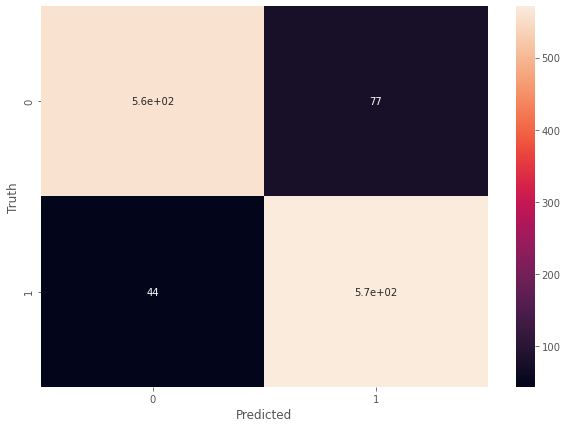

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Gender classification with dlib features

In [213]:
from imutils import face_utils
import dlib
import imutils

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

In [214]:
def get_landmarks(img_path):
    
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)
    shape = None
    for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
    return shape

In [259]:
DIR_t = './celeba_test/img/'
dft = pd.read_csv('./celeba_test/labels.csv', sep = '\s+')
dft.head()

,img_name,gender,smiling
0,0.jpg,-1,-1
1,1.jpg,-1,1
2,2.jpg,1,1
3,3.jpg,1,1
4,4.jpg,-1,-1


In [262]:
test_feat = []
gender_t = []
smile_t = []

for name in df.img_name:
    x = get_landmarks(DIR+name)
    if x is not None:
        test_feat.append(x)
        gender_t.append(df.loc[df.img_name == name].gender)
        smile_t.append(df.loc[df.img_name == name].smiling)

test_feat = np.array(test_feat).reshape(len(test_feat),68*2).astype(float)
gender_t = np.array(gender_t).ravel()
smile_t = np.array(smile_t).ravel()

In [215]:
features = []
gender = []
smile = []

for name in df.img_name:
    x = get_landmarks(DIR+name)
    if x is not None:
        features.append(x)
        gender.append(df.loc[df.img_name == name].gender)
        smile.append(df.loc[df.img_name == name].smiling)

feat = np.array(features).reshape(len(features),68*2).astype(float)
gender = np.array(gender).ravel()
smile = np.array(smile).ravel()

In [ ]:
len(feat)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(feat, smile, random_state=0)

Model fitting, need to try CNN / MLP. KNN performs ok for smile but shit for gender, SVM does okish (83-86%)

Try to optimize xgb and try neural networks


In [269]:
start = time.time()
model = xgb.XGBClassifier(learning_rate=0.3,n_estimators=70, max_depth=5,min_child_weight=1,gamma=0,colsample_bytree=0.3)
model.fit(feat, gender)
print(model.score(test_feat,gender_t))
end = time.time()
print('elapsed time: ' +str(end-start))

0.9218944744495222
elapsed time: 1.1628894805908203


In [267]:
start = time.time()
model = xgb.XGBClassifier(learning_rate=0.3,n_estimators=70, max_depth=5,min_child_weight=1,gamma=0,colsample_bytree=0.3)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
end = time.time()
print('elapsed time: ' +str(end-start))

0.9986149584487535
elapsed time: 0.45604634284973145


In [264]:
print(model.score(test_feat,gender_t))

0.9218944744495222


In [56]:
parameters = {"learning_rate"    : [0.1,0.3,1,3 ] ,
 "n_estimators" : [100,200,300,400,500],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [33]:
n_estimators = [500,700,1000]
learning_rate = [0.1, 0.3, 0.01 ,0.001]
max_depth = [ 3, 4, 5, 6, 8,10]
min_child_weight = [1,3,5]
gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
colsample_bytree= [0.0, 0.3, 0.4, 0.5 , 0.7 ]

param_grid = dict(colsample_bytree=colsample_bytree)
#param_grid = dict(min_child_weight=min_child_weight)

In [36]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
model = xgb.XGBClassifier(learning_rate=0.3,n_estimators=700, max_depth=5,min_child_weight=1,gamma=0,colsample_bytree=0.3)
grid_search = GridSearchCV(model, param_grid=param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.963500 using {'colsample_bytree': 0.7}
0.920145 (0.006937) with: {'colsample_bytree': 0.0}
0.963049 (0.005607) with: {'colsample_bytree': 0.3}
0.962041 (0.005416) with: {'colsample_bytree': 0.4}
0.962108 (0.007234) with: {'colsample_bytree': 0.5}
0.963500 (0.006002) with: {'colsample_bytree': 0.7}


In [258]:
model = xgb.XGBClassifier(learning_rate=0.3,n_estimators=70, max_depth=5,min_child_weight=1,gamma=0,colsample_bytree=0.7,subsample= 1)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
print(model.score(X_test,y_test))

Wall time: 1.02 s
0.8953488372093024


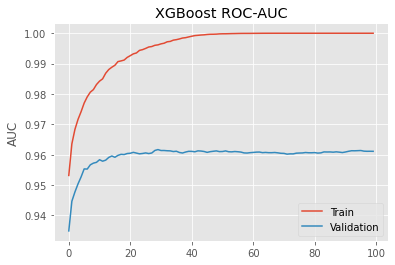

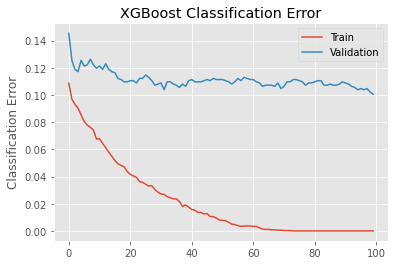

In [228]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost ROC-AUC')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [229]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8662790697674418
elapsed time: 0.7350969314575195


In [230]:
#SVM
start = time.time()
model = SVC()
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
end = time.time()
print('elapsed time: ' +str(end-start))

0.8803986710963455
elapsed time: 1.8023936748504639
